In [1]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import scipy as sp
from scipy import sparse
import scvelo

/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:


def buildAnndataFromStarCurr(path, filter=False):
    """Generate an anndata object from the STAR aligner output folder"""
    path=path
    # Load Read Counts
    X = sc.read_mtx(path+'Gene/raw/matrix.mtx')

    # Transpose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects
    X = X.X.transpose()

    # Load the 3 matrices containing Spliced, Unspliced and Ambigous reads
    mtxU = np.loadtxt(path+'Velocyto/raw/unspliced.mtx', skiprows=3, delimiter=' ')
    mtxS = np.loadtxt(path+'Velocyto/raw/spliced.mtx', skiprows=3, delimiter=' ')
    mtxA = np.loadtxt(path+'Velocyto/raw/ambiguous.mtx', skiprows=3, delimiter=' ')

    # Extract sparse matrix shape informations from the third row
    shapeU = np.loadtxt(path+'Velocyto/raw/unspliced.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)
    shapeS = np.loadtxt(path+'Velocyto/raw/spliced.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)
    shapeA = np.loadtxt(path+'Velocyto/raw/ambiguous.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)

    # Read the sparse matrix with csr_matrix((data, (row_ind, col_ind)), shape=(M, N))
    # Subract -1 to rows and cols index because csr_matrix expects a 0 based index
    # Traspose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects

    spliced = sparse.csr_matrix((mtxS[:,2], (mtxS[:,0]-1, mtxS[:,1]-1)), shape = shapeS).transpose()
    unspliced = sparse.csr_matrix((mtxU[:,2], (mtxU[:,0]-1, mtxU[:,1]-1)), shape = shapeU).transpose()
    ambiguous = sparse.csr_matrix((mtxA[:,2], (mtxA[:,0]-1, mtxA[:,1]-1)), shape = shapeA).transpose()

    # Load Genes and Cells identifiers
    obs = pd.read_csv(path+'Velocyto/raw/barcodes.tsv',
                  header = None, index_col = 0)

    # Remove index column name to make it compliant with the anndata format
    obs.index.name = None

    var = pd.read_csv(path+'Velocyto/raw/features.tsv', sep='\t',
                                    names = ('gene_ids', 'feature_types'), index_col = 1)
  
    # Build AnnData object to be used with ScanPy and ScVelo
    adata = anndata.AnnData(X = X, obs = obs, var = var,
                                                 layers = {'spliced': spliced, 'unspliced': unspliced, 'ambiguous': ambiguous})
    adata.var_names_make_unique()

    # Subset Cells based on STAR filtering
    if filter:
        selected_barcodes = pd.read_csv(path+'Gene/filtered/barcodes.tsv', header = None)
        adata = adata[selected_barcodes[0]]

    return adata.copy()

In [5]:
adata_genbank = buildAnndataFromStarCurr("RNA Sequencing Data/raw_reads/day2_bfp_genbank/day2_bfp_genbank/", filter=True)

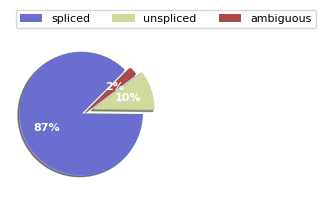

AnnData object with n_obs × n_vars = 862 × 40413
    var: 'gene_ids', 'feature_types'
    layers: 'spliced', 'unspliced', 'ambiguous'
Total counts: 48245712.0
Spliced: 39565377.0
Unspliced: 4956359.0
Ambiguous: 1048151.0
Gene: Nanog
Total count: 295.0
Spliced: 287.0
Unspliced: 55.0
Ambiguous: 2.0
Nonzero total: 115


In [8]:
# Analyze adata

scvelo.pl.proportions(adata_genbank, groupby='group')
print(adata_genbank)
print(f"Total counts: {adata_genbank.X.sum()}")
print(f"Spliced: {adata_genbank.layers["spliced"].sum()}")
print(f"Unspliced: {adata_genbank.layers["unspliced"].sum()}")
print(f"Ambiguous: {adata_genbank.layers["ambiguous"].sum()}")
gene = "Nanog"
print(f"Gene: {gene}")
print(f"Total count: {adata_genbank[:, gene].X.sum()}")
print(f"Spliced: {adata_genbank[:, gene].layers["spliced"].sum()}")
print(f"Unspliced: {adata_genbank[:, gene].layers["unspliced"].sum()}")
print(f"Ambiguous: {adata_genbank[:, gene].layers["ambiguous"].sum()}")
print(f"Nonzero total: {(adata_genbank[:, gene].X!=0).sum()}")

In [9]:
adata = buildAnndataFromStarCurr("RNA Sequencing Data/raw_reads/star_counts/", filter=True)

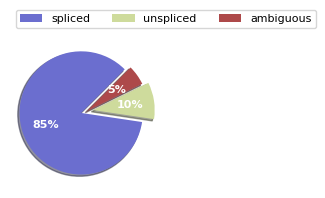

AnnData object with n_obs × n_vars = 863 × 33696
    var: 'gene_ids', 'feature_types'
    layers: 'spliced', 'unspliced', 'ambiguous'
Total counts: 49860424.0
Spliced: 38672897.0
Unspliced: 4616868.0
Ambiguous: 2411854.0
Gene: Nanog
Total count: 295.0
Spliced: 287.0
Unspliced: 54.0
Ambiguous: 2.0
Nonzero total: 115


In [10]:
# Analyze adata

scvelo.pl.proportions(adata, groupby='group')
print(adata)
print(f"Total counts: {adata.X.sum()}")
print(f"Spliced: {adata.layers["spliced"].sum()}")
print(f"Unspliced: {adata.layers["unspliced"].sum()}")
print(f"Ambiguous: {adata.layers["ambiguous"].sum()}")
gene = "Nanog"
print(f"Gene: {gene}")
print(f"Total count: {adata[:, gene].X.sum()}")
print(f"Spliced: {adata[:, gene].layers["spliced"].sum()}")
print(f"Unspliced: {adata[:, gene].layers["unspliced"].sum()}")
print(f"Ambiguous: {adata[:, gene].layers["ambiguous"].sum()}")
print(f"Nonzero total: {(adata[:, gene].X!=0).sum()}")

AnnData object with n_obs × n_vars = 983 × 34183
    var: 'gene_name'
    layers: 'spliced', 'unspliced'
14703023.0
4933591.0


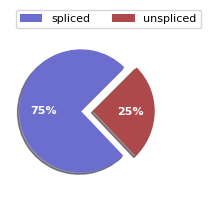

Gene: Nanog
Unspliced: 46.0
Spliced: 8.0
Nonzero: 7


In [97]:
# Compare with previous adata file

old_path = "RNA Sequencing Data/raw_reads/h5ad_files/Repro_Day2_BFP/counts_unfiltered/adata.h5ad"
old_adata = sc.read_h5ad(old_path)
print(old_adata)
print(old_adata.layers["spliced"].sum())
print(old_adata.layers["unspliced"].sum())
scvelo.pl.proportions(old_adata)
gene = "Nanog"
print("Gene:", gene)
print(f"Unspliced: {old_adata[:, old_adata.var["gene_name"]==gene].layers["unspliced"].sum()}")
print(f"Spliced: {old_adata[:, old_adata.var["gene_name"]==gene].layers["spliced"].sum()}")
print(f"Nonzero: {(old_adata[:, old_adata.var["gene_name"]==gene].X!=0).sum()}")

In [95]:
# Seurat dataframe
seurat_adata = sc.read_h5ad("RNA Sequencing Data/220701Pool1-Pool3.h5ad")

In [73]:
print(seurat_adata.obs["orig.ident"])

AAACGAATCGACCTAA-1_1    11
AAAGTGAAGGAACTAT-1_1    11
AAATGGAAGACGAGCT-1_1    11
AACAAAGGTAGCTGAG-1_1    11
AACAAGACATAGTCGT-1_1    11
                        ..
TTTGGAGCATCCGTTC-1_2     0
TTTGGAGTCGTAGGAG-1_2     0
TTTGGTTCATGCTGCG-1_2     0
TTTGTTGAGGCGTCCT-1_2     0
TTTGTTGTCCGCTAGG-1_2     0
Name: orig.ident, Length: 13315, dtype: int32
